New red QSO Code

In [2]:
#imports placed here
import os
import pickle 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scripts import rgbImageGenerator
from scripts.data_aggregate_target import TargetData
import glob
import shutil
import copy
import re

In [12]:
def toFlux(magnitude,zeroflux):
    return (zeroflux*(10**(-(magnitude)/(2.5))))
def toMagnitude(flux,zeroflux):
    return (-2.5)*np.log10(flux/zeroflux)
def CollectSpectroscopicData(target):
    wavelength,qso,host = np.loadtxt(f"results/PyQSOFit_test/{target}_data.csv",delimiter=",",unpack=True)
    GBandWavelength,GBandTransmissivity = np.loadtxt("data/filters/r_band.csv",skiprows=1,unpack=True)

    #first trim the spectrum data to only that within the bounds of the g band
    abswavedifferenceMin,abswavedifferenceMax = np.abs(np.subtract(wavelength,min(GBandWavelength))),np.abs(np.subtract(wavelength,max(GBandWavelength)))
    minIndex = np.where(abswavedifferenceMin == min(abswavedifferenceMin))[0][0]
    maxIndex = np.where(abswavedifferenceMax == min(abswavedifferenceMax))[0][0]

    wavelength = wavelength[minIndex:maxIndex]
    qso = qso[minIndex:maxIndex]
    host = host[minIndex:maxIndex]
    #calculate the galaxy fraction from these values:
    integratedqso = np.trapz(qso,wavelength)
    integratedhost = np.trapz(host,wavelength)
    spectroscopicGalaxyFraction = integratedhost/(integratedhost+integratedqso)
    #now iterate over the trimmed wavelength to find the nearest transmissivity
    interpolatedTransmissivity = []
    for i,value in enumerate(wavelength):
        absdifference = abs(np.subtract(GBandWavelength,value))
        nearestIndex = np.where(absdifference == min(absdifference))[0][0]
        #spectroscopic data has a higher resolution than filter data - so find out if the target wavelength is larger or smaller
        #then, find the next or previous point which the target value should lie between. Interpolate linearly for the average value
        if value < GBandWavelength[nearestIndex]:
            if i != 0:
                secondIndex = nearestIndex-1
            else:
                secondIndex = copy.deepcopy(nearestIndex)
        else:
            if i != (len(wavelength)-1):
                secondIndex = nearestIndex+1
            else:
                secondIndex = copy.deepcopy(nearestIndex)
                
        interpolatedTransmissivity.append(np.average([GBandTransmissivity[nearestIndex],GBandTransmissivity[secondIndex]]))

    #now adjust for transmissivity for what HSC would see
    transAdjustedFluxQSO = np.multiply(qso,interpolatedTransmissivity)
    transAdjustedFluxHost = np.multiply(host,interpolatedTransmissivity)

    #now need to integrate over the transadjusted specific flux - using trapezoid rule
    integratedQSOFlux = np.trapz(transAdjustedFluxQSO,wavelength)
    integratedHostFlux = np.trapz(transAdjustedFluxHost,wavelength)
    galaxyFraction = integratedHostFlux/(integratedHostFlux+integratedQSOFlux)
    #to find the magnitude, need to convert fluxes to photon counts
    photonCountsByWavelengthQSO = []
    photonCountsByWavelengthHost = []
    for i,x in enumerate(transAdjustedFluxQSO):
        energyPerPhotonSI = ((6.626e-34)*(3e8))/(wavelength[i]/1e10) # energy per photon in si units at this wavelength, converted wavelength to m from angstroms
        energyPerPhotonErgs = energyPerPhotonSI*1e7
        photonCountsByWavelengthQSO.append((transAdjustedFluxQSO[i]*10e-17)/energyPerPhotonErgs)
        photonCountsByWavelengthHost.append((transAdjustedFluxHost[i]*10e-17)/energyPerPhotonErgs)
    photonCountsQSO = np.trapz(photonCountsByWavelengthQSO,wavelength)
    photonCountsHost = np.trapz(photonCountsByWavelengthHost,wavelength)
    #currently in photons/s/cm^2
    fluxMag0 = 63095734448.01944
    QSOSpecMagnitude = toMagnitude(photonCountsQSO*10000,fluxMag0) #multiplying by 10,000 to go from photons/s/cm^2 to photons/s/m^2
    HostSpecMagnitude = toMagnitude(photonCountsHost*10000,fluxMag0)
    return {"host magnitude":HostSpecMagnitude,"qso magnitude":QSOSpecMagnitude,"galaxy fraction":galaxyFraction}

In [3]:
#aggregate data and store in pickle file
#aggregatedData = TargetData("39627670568314673",r"data/spectra",r"results/desitargets/includinghost",r"results/PyQSOFit_test",r"data/DESICatalogue.csv")
#print(aggregatedData.specFGal)
dataMasterlist = []
catalogueAddress = "data/DESICatalogue.csv"
objects = list(pd.read_csv(catalogueAddress)["DESI_ID"])
for object in objects:
        dataMasterlist.append(TargetData(object,r"data/spectra",r"results/desitargets/includinghost",r"results/PyQSOFit_test",catalogueAddress))
file = open("results/resultMasterlist.pkl","wb")
pickle.dump(dataMasterlist,file)
file.close()

Attempted to collect spectral decomposition data for 39627859706249278, but file/s are missing
Attempted to collect spectral decomposition data for 39627670681553378, but file/s are missing
Attempted to collect spectral decomposition data for 39627712893032761, but file/s are missing
Attempted to collect r band image decomposition data for 39627740080506904, but the file is missing
Attempted to collect r band image decomposition data for 39633123171897305, but the file is missing
Attempted to collect r band image decomposition data for 39633158370494271, but the file is missing
Attempted to collect r band image decomposition data for 39627775723704295, but the file is missing
Attempted to collect r band image decomposition data for 39627746090943288, but the file is missing
Attempted to collect r band image decomposition data for 39627746153860634, but the file is missing
Attempted to collect r band image decomposition data for 39627817935180000, but the file is missing
Attempted to co

colour datapoints: 11
G values: 11,R values: 11,I values: 11
Average chi 2 values:
G values: 3.685522523251491,R values: 11.308294432670552,I values: 35.524462034778104
chi std
G values: 3.1999455226253652,R values: 13.44343959985294,I values: 29.012301126048477
The mean reduced chi squared is 0.469 with a standard deviation 0.141
The median reduced chi squared is 0.433
object list with reduced chi square value above 2:
{'G': ['39627652490857032', '39627670568314673', '39627896758735663', '39627736897033394', '39627745415661526', '39627751094747557', '39627815557011818'], 'R': ['39627899921240501', '39627652490857032', '39627670568314673', '39627896758735663', '39627749140204970', '39627736897033394', '39627745415661526', '39627751094747557', '39627815557011818'], 'I': ['39627899921240501', '39627652490857032', '39627670568314673', '39627896758735663', '39627749140204970', '39627751509987377', '39627736897033394', '39627745415661526', '39627751094747557', '39627815557011818', '39627908

Text(0.5, 0, 'magnitude')

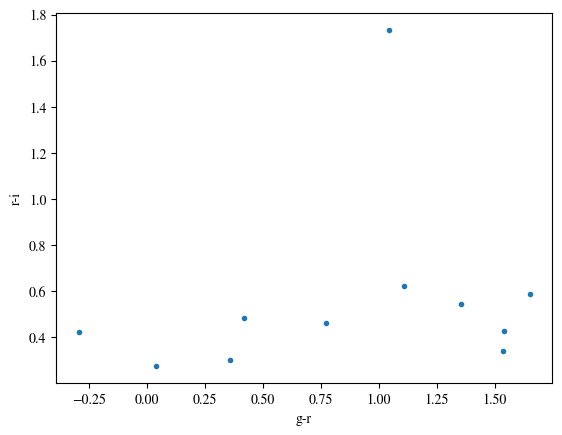

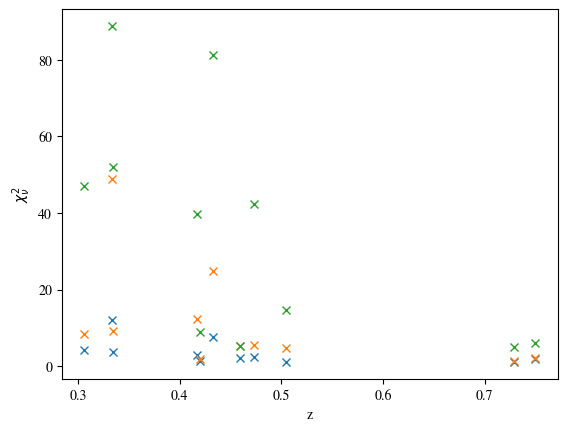

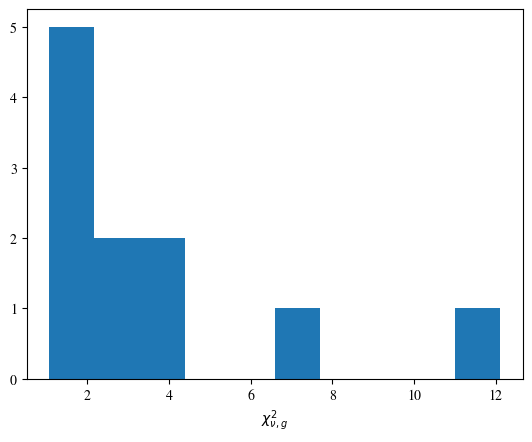

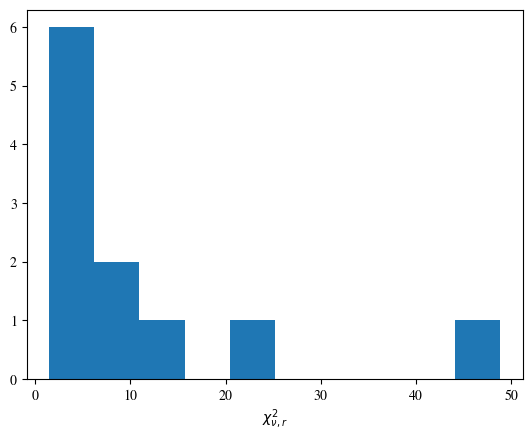

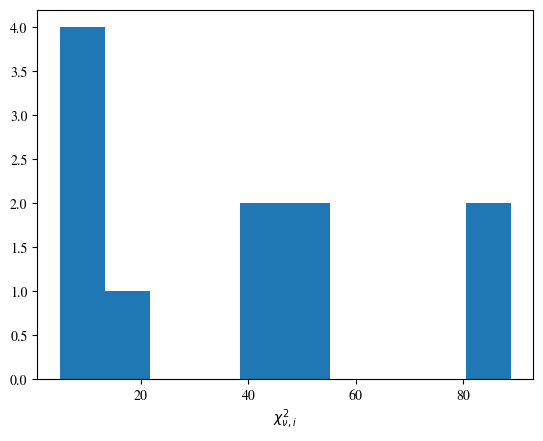

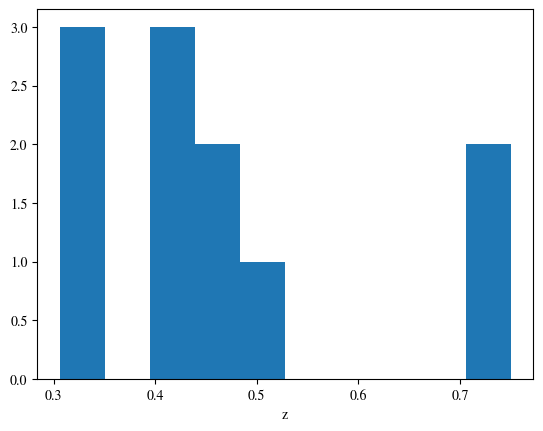

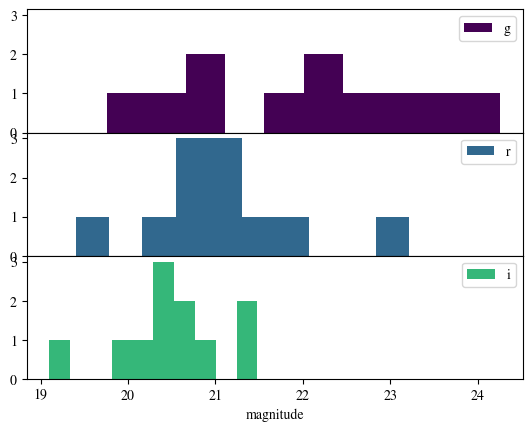

In [6]:
#Here we will inspect the contents of the pickle files for fits which exclude the host component
#first get a list of directory contents and catalogue:
import matplotlib


fileAddress = "results/desitargets/excludinghost"
catalogue = pd.read_csv("data/DESICatalogue.csv")
objID = []
files = list(os.listdir(fileAddress))
reducedChiSquareds = {"G":[],"R":[],"I":[]}
highChiSquareObjects = {"G":[],"R":[],"I":[]}
magnitudes = {"G":[],"R":[],"I":[]}
Zs = []
fluxMag0 = 63095734448.01944
for file in files:
    #check that the file is a directory:
    if "." in file:
        continue
    pklFiles = glob.glob(f"{fileAddress}/{file}/fitting_results/*.pkl")
    if len(pklFiles) == 0:
        print(f"No .pkl files found for {file}")
        continue 
    obj_No = list(catalogue["DESI_ID"]).index(int(file))
    objID.append(obj_No)
    z = list(catalogue["Z_DESI"])[obj_No]
    Zs.append(z)
    bandsForObject = ""
    for pickleFile in pklFiles:
        bandsForObject += f"{pickleFile[-5]}"
        output = pickle.load(open(pickleFile,"rb"))
        #print(output.final_result_ps)
        #print(output.reduced_Chisq)
        magnitudes[pickleFile[-5].upper()].append(output.final_result_ps[0]["magnitude"])
        reducedChiSquareds[pickleFile[-5].upper()].append(output.reduced_Chisq)
        if output.reduced_Chisq >= 2:
            highChiSquareObjects[pickleFile[-5].upper()].append(file)
        
    for band in ["g","r","i"]:
        if band not in bandsForObject:
            reducedChiSquareds[band.upper()].append(-1) #appending invalid value to represent missing data
            magnitudes[band.upper()].append(-1)
#colour statistics

GRColour = []
RIColour = []
#want g-r colour and r-i colour from set with complete results
for i, j in enumerate(magnitudes["G"]):
    #check that all bands have valid data
    if -1 in [magnitudes["G"][i],magnitudes["R"][i],magnitudes["I"][i]]:
        #ignore this index if -1 is in this gri set
        continue
    GRColour.append(magnitudes["G"][i] - magnitudes["R"][i])
    RIColour.append(magnitudes["R"][i] - magnitudes["I"][i])
print(f"colour datapoints: {len(GRColour)}")

#Counting
#G, R, I number of results, average chi2
ValidOutputs = {"G":[mag for mag in magnitudes["G"] if mag != -1],
                "R":[mag for mag in magnitudes["R"] if mag != -1],
                "I":[mag for mag in magnitudes["I"] if mag != -1]}
ValidOutputsChi = {"G":[chi for chi in reducedChiSquareds["G"] if chi != -1],
                "R":[chi for chi in reducedChiSquareds["R"] if chi != -1],
                "I":[chi for chi in reducedChiSquareds["I"] if chi != -1]}
print(f"G values: {len(ValidOutputs["G"])},R values: {len(ValidOutputs["R"])},I values: {len(ValidOutputs["I"])}")
print("Average chi 2 values:")
print(f"G values: {np.mean(ValidOutputsChi["G"])},R values: {np.mean(ValidOutputsChi["R"])},I values: {np.mean(ValidOutputsChi["I"])}")
print("chi std")
print(f"G values: {np.std(ValidOutputsChi["G"])},R values: {np.std(ValidOutputsChi["R"])},I values: {np.std(ValidOutputsChi["I"])}")
#plt.ylim(top=2,bottom=-1)
plt.plot(GRColour,RIColour,linestyle="None",marker=".")
plt.xlabel("g-r")
plt.ylabel("r-i")
#chi2 statistics
print(f"The mean reduced chi squared is {round(np.mean(Zs),3)} with a standard deviation {round(np.std(Zs),3)}")
print(f"The median reduced chi squared is {round(np.median(Zs),3)}")
print("object list with reduced chi square value above 2:")
print(highChiSquareObjects)
#rgbImageGenerator.generateImages(highChiSquareObjects["I"],r"rgbimages/highChiSquare",r"data/images") #image generation of high chi square objects
print(f"{len(highChiSquareObjects["G"])} g band objects with reduced chi square values over 2")
print(f"{len(highChiSquareObjects["R"])} r band objects with reduced chi square values over 2")
print(f"{len(highChiSquareObjects["I"])} i band objects with reduced chi square values over 2")
#displaying plots:
plt.figure()
plt.plot(Zs,reducedChiSquareds["G"],linestyle="None",marker="x",label="g")
plt.plot(Zs,reducedChiSquareds["R"],linestyle="None",marker="x",label="r")
plt.plot(Zs,reducedChiSquareds["I"],linestyle="None",marker="x",label="i")
plt.xlabel("z")
plt.ylabel(r"$\chi^{2}_{\nu}$")
plt.figure()
plt.xlabel(r"$\chi^{2}_{\nu, g}$")
plt.hist(reducedChiSquareds["G"])
plt.figure()
plt.xlabel(r"$\chi^{2}_{\nu, r}$")
plt.hist(reducedChiSquareds["R"])
plt.figure()
plt.xlabel(r"$\chi^{2}_{\nu, i}$")
plt.hist(reducedChiSquareds["I"])
plt.figure()
plt.hist(Zs)
plt.xlabel("z")
print(f"{min(Zs)} < z < {max(Zs)}")
print(f"{min(ValidOutputs['G'])} < m(g) < {max(ValidOutputs['G'])}")
print(f"{min(ValidOutputs['R'])} < m(r) < {max(ValidOutputs['R'])}")
print(f"{min(ValidOutputs['I'])} < m(i) < {max(ValidOutputs['I'])}")
stackedPlot = plt.figure()
cmap = matplotlib.colormaps['viridis']
colors = cmap(np.linspace(0, 1, 4))
gs = stackedPlot.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].hist(ValidOutputs["G"],label="g",color=colors[0])
axs[0].legend(loc="best")
axs[1].hist(ValidOutputs["R"],label="r",color=colors[1])
axs[1].legend(loc="best")
axs[2].hist(ValidOutputs["I"],label="i",color=colors[2])
axs[2].legend(loc="best")
axs[2].set_xlabel("magnitude")

In [26]:
#Want to collect final plots for high chi 2 outputs
outputDirectory = r"results/cut50/excludinghost"
files = list(os.listdir(outputDirectory))
for file in files:
    if file in highChiSquareObjects["G"]:
        shutil.copyfile(f"{outputDirectory}/{file}/fitting_results/{file}-result-band-g_qso_final_plot.pdf",f"plots/GBand/{file}-result-band-g_qso_final_plot.pdf")
    if file in highChiSquareObjects["R"]:
        shutil.copyfile(f"{outputDirectory}/{file}/fitting_results/{file}-result-band-r_qso_final_plot.pdf",f"plots/RBand/{file}-result-band-r_qso_final_plot.pdf")
    if file in highChiSquareObjects["I"]:
        shutil.copyfile(f"{outputDirectory}/{file}/fitting_results/{file}-result-band-i_qso_final_plot.pdf",f"plots/IBand/{file}-result-band-i_qso_final_plot.pdf")
    else:
        continue

{'G': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'R': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'I': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
39627877838225923
Largest improvement in G band: 39627736897033394
Largest improvement in R band: 39627736897033394
Largest improvement in I band: 39627736897033394


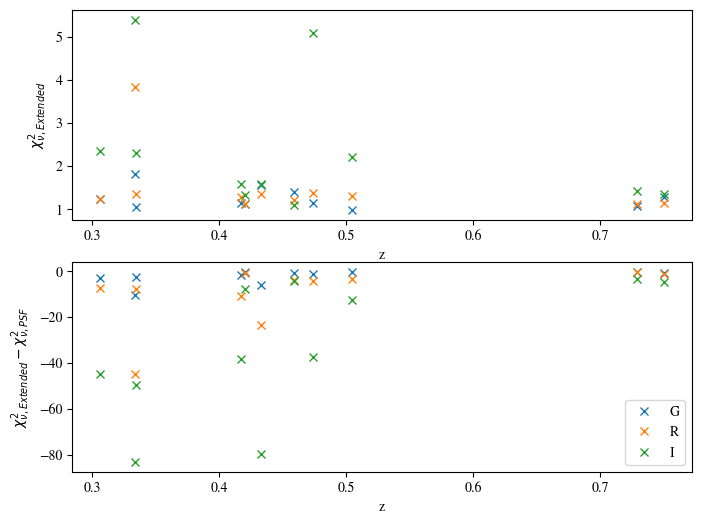

In [7]:
#Comparing chi2 change when adding a host component
#collect the objects in the bands where their chi2 is high from folder of host-decomposed results
resultFolder = r"results/desitargets/includinghost"
objID_Host = {"G":[],"R":[],"I":[]}
reducedChiSquareds_Host = {"G":[],"R":[],"I":[]}
highChiSquareObjects_Host = {"G":[],"R":[],"I":[]}
magnitudes_Host = {"G":[],"R":[],"I":[]}
QSOmagnitudes_Host = {"G":[],"R":[],"I":[]}
Zs_host = {"G":[],"R":[],"I":[]}
fluxMag0 = 63095734448.01944
for file in list(os.listdir(resultFolder)):
    #check that the file is a directory:
    if "." in file:
        continue
    pklFiles = glob.glob(f"{resultFolder}/{file}/fitting_results/*.pkl")
    if len(pklFiles) == 0:
        print(f"No .pkl files found for {file}")
        continue 
    obj_No = list(catalogue["DESI_ID"]).index(int(file))
    z = list(catalogue["Z_DESI"])[obj_No]
    
    bandsForObject = ""
    for pickleFile in pklFiles:
        bandsForObject += f"{pickleFile[-5]}"
        output = pickle.load(open(pickleFile,"rb"))
        #print(output.final_result_ps)
        #print(output.final_result_galaxy)
        #print(output.reduced_Chisq)
        Zs_host[pickleFile[-5].upper()].append(z)
        QSOmagnitudes_Host[pickleFile[-5].upper()].append(output.final_result_ps[0]["magnitude"])
        magnitudes_Host[pickleFile[-5].upper()].append(output.final_result_galaxy[0]["magnitude"])
        reducedChiSquareds_Host[pickleFile[-5].upper()].append(output.reduced_Chisq)
        objID_Host[pickleFile[-5].upper()].append(obj_No) # this will correspond to the index of the objects in the other list
        if output.reduced_Chisq >= 2:
            highChiSquareObjects_Host[pickleFile[-5].upper()].append(file)

#now compare values and collect galaxy fractions
chiDiff = {"G":[],"R":[],"I":[]}
improvedID = {"G":[],"R":[],"I":[]}
for band in ["G","R","I"]:
    for i, ID in enumerate(objID_Host[band]):
        chiDiff[band].append(reducedChiSquareds_Host[band][i]-reducedChiSquareds[band][ID])
        if chiDiff[band][-1] <= 0:
            improvedID[band].append(ID)

plt.figure(figsize=(8,6)) 
plt.subplot(2,1,1)
plt.plot(Zs_host["G"],reducedChiSquareds_Host["G"],linestyle="None",marker="x",label="G")
plt.plot(Zs_host["R"],reducedChiSquareds_Host["R"],linestyle="None",marker="x",label="R")
plt.plot(Zs_host["I"],reducedChiSquareds_Host["I"],linestyle="None",marker="x",label="I")
plt.xlabel("z")
plt.ylabel(r"$\chi^{2}_{\nu,Extended}$")
plt.subplot(2,1,2)
plt.plot(Zs_host["G"],chiDiff["G"],linestyle="None",marker="x",label="G")
plt.plot(Zs_host["R"],chiDiff["R"],linestyle="None",marker="x",label="R")
plt.plot(Zs_host["I"],chiDiff["I"],linestyle="None",marker="x",label="I")

plt.xlabel("z")
plt.ylabel(r"$\chi^{2}_{\nu,Extended} - \chi^{2}_{\nu,PSF}$")
plt.legend(loc="best")
print(improvedID)
print(list(os.listdir(r"results/cut50_ss/includinghost"))[9])

print(f"Largest improvement in G band: {list(os.listdir(r"results/desitargets/includinghost"))[np.where(chiDiff["G"] == min(chiDiff["G"]))[0][0]]}")
print(f"Largest improvement in R band: {list(os.listdir(r"results/desitargets/includinghost"))[np.where(chiDiff["R"] == min(chiDiff["R"]))[0][0]]}")
print(f"Largest improvement in I band: {list(os.listdir(r"results/desitargets/includinghost"))[np.where(chiDiff["I"] == min(chiDiff["I"]))[0][0]]}")

In [3]:
#Here will run the decomposition code for tests
from scripts import decomposition
imageDirectory = "data/images"
cataloguePath = r"data/RedQSOCatalogue.csv"
saveTo = r"results/cut50_ss/includinghost"
start = int(input("Start index: "))
stop = int(input("End index: "))
band = str(input("Band: "))
decomposition.galightDecompose(imageDirectory,cataloguePath,saveTo,True,start,stop,band,band)

KeyboardInterrupt: Interrupted by user

galaxy fraction from spectroscopy within g band filter bandwidth: 0.9033182341690281
expected galaxy fraction from hsc: 0.9084532404300038
galaxy fraction from hsc: 0.9132986202367864
Spectroscopy derived host magnitude if observed through hsc: 20.04198793066965
HSC image derived host magnitude 20.599818268016172


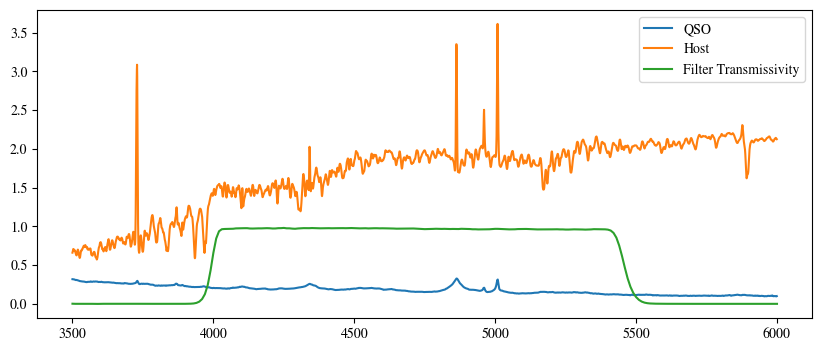

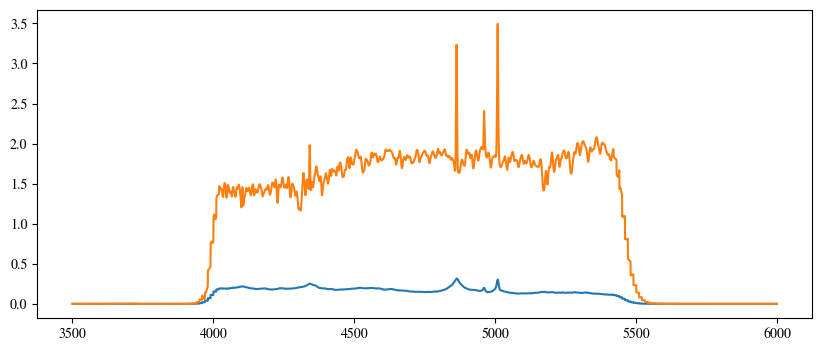

In [4]:
def toFlux(magnitude,zeroflux):
    return (zeroflux*(10**(-(magnitude)/(2.5))))
def toMagnitude(flux,zeroflux):
    return (-2.5)*np.log10(flux/zeroflux)

target = "39627736897033394"
wavelength,qso,host = np.loadtxt(f"results/PyQSOFit_test/{target}_data.csv",delimiter=",",unpack=True)
GBandWavelength,GBandTransmissivity = np.loadtxt("data/filters/g_band.csv",skiprows=1,unpack=True)

#first trim the spectrum data to only that within the bounds of the g band
abswavedifferenceMin,abswavedifferenceMax = np.abs(np.subtract(wavelength,min(GBandWavelength))),np.abs(np.subtract(wavelength,max(GBandWavelength)))
minIndex = np.where(abswavedifferenceMin == min(abswavedifferenceMin))[0][0]
maxIndex = np.where(abswavedifferenceMax == min(abswavedifferenceMax))[0][0]

wavelength = wavelength[minIndex:maxIndex]
qso = qso[minIndex:maxIndex]
host = host[minIndex:maxIndex]
#calculate the galaxy fraction from these values:
integratedqso = np.trapz(qso,wavelength)
integratedhost = np.trapz(host,wavelength)
spectroscopicGalaxyFraction = integratedhost/(integratedhost+integratedqso)
#now iterate over the trimmed wavelength to find the nearest transmissivity
interpolatedTransmissivity = []
for i,value in enumerate(wavelength):
    absdifference = abs(np.subtract(GBandWavelength,value))
    nearestIndex = np.where(absdifference == min(absdifference))[0][0]
    #spectroscopic data has a higher resolution than filter data - so find out if the target wavelength is larger or smaller
    #then, find the next or previous point which the target value should lie between. Interpolate linearly for the average value
    if value < GBandWavelength[nearestIndex]:
        if i != 0:
            secondIndex = nearestIndex-1
        else:
            secondIndex = copy.deepcopy(nearestIndex)
    else:
        if i != (len(wavelength)-1):
            secondIndex = nearestIndex+1
        else:
            secondIndex = copy.deepcopy(nearestIndex)
            
    interpolatedTransmissivity.append(np.average([GBandTransmissivity[nearestIndex],GBandTransmissivity[secondIndex]]))

#now adjust for transmissivity for what HSC would see
transAdjustedFluxQSO = np.multiply(qso,interpolatedTransmissivity)
transAdjustedFluxHost = np.multiply(host,interpolatedTransmissivity)

#now need to integrate over the transadjusted specific flux - using trapezoid rule
integratedQSOFlux = np.trapz(transAdjustedFluxQSO,wavelength)
integratedHostFlux = np.trapz(transAdjustedFluxHost,wavelength)

galaxyFraction = integratedHostFlux/(integratedHostFlux+integratedQSOFlux)

#compare to HSC
HSCResult = pickle.load(open(f"results/desitargets/includinghost/{target}/fitting_results/{target}-result-band-g.pkl","rb"))
fluxMag0 = 63095734448.01944
HSCGalaxyMagnitude = HSCResult.final_result_galaxy[0]["magnitude"]
HSCQSOMagnitude = HSCResult.final_result_ps[0]["magnitude"]
HSCHostFlux = toFlux(HSCGalaxyMagnitude,fluxMag0)
HSCQSOFlux = toFlux(HSCQSOMagnitude,fluxMag0)
HSCGalaxyFraction = HSCHostFlux/(HSCHostFlux+HSCQSOFlux)

print(f"galaxy fraction from spectroscopy within g band filter bandwidth: {spectroscopicGalaxyFraction}")
print(f"expected galaxy fraction from hsc: {galaxyFraction}")
print(f"galaxy fraction from hsc: {HSCGalaxyFraction}")

#to find the magnitude, need to convert fluxes to photon counts
photonCountsByWavelengthQSO = []
photonCountsByWavelengthHost = []
for i,x in enumerate(transAdjustedFluxQSO):
    energyPerPhotonSI = ((6.626e-34)*(3e8))/(wavelength[i]/1e10) # energy per photon in si units at this wavelength, converted wavelength to m from angstroms
    energyPerPhotonErgs = energyPerPhotonSI*1e7
    photonCountsByWavelengthQSO.append((transAdjustedFluxQSO[i]*10e-17)/energyPerPhotonErgs)
    photonCountsByWavelengthHost.append((transAdjustedFluxHost[i]*10e-17)/energyPerPhotonErgs)
photonCountsQSO = np.trapz(photonCountsByWavelengthQSO,wavelength)
photonCountsHost = np.trapz(photonCountsByWavelengthHost,wavelength)
#currently in photons/s/cm^2
QSOSpecMagnitude = toMagnitude(photonCountsQSO*10000,fluxMag0) #multiplying by 10,000 to go from photons/s/cm^2 to photons/s/m^2
HostSpecMagnitude = toMagnitude(photonCountsHost*10000,fluxMag0)

#now compare to HSC
print(f"Spectroscopy derived host magnitude if observed through hsc: {HostSpecMagnitude}")
print(f"HSC image derived host magnitude {HSCGalaxyMagnitude}")

#plotting
plt.figure(figsize=(10,4))
plt.plot(wavelength,qso,label="QSO")
plt.plot(wavelength,host,label="Host")
plt.plot(GBandWavelength,GBandTransmissivity,label="Filter Transmissivity")
plt.legend(loc="best")
plt.figure(figsize=(10,4))
plt.plot(wavelength,transAdjustedFluxQSO)
plt.plot(wavelength,transAdjustedFluxHost)


Mean difference: 0.025273068423520183+-0.21599001625936531


Text(0.5, 0, '|$f_{gal,spec} - f_{gal,img}|$')

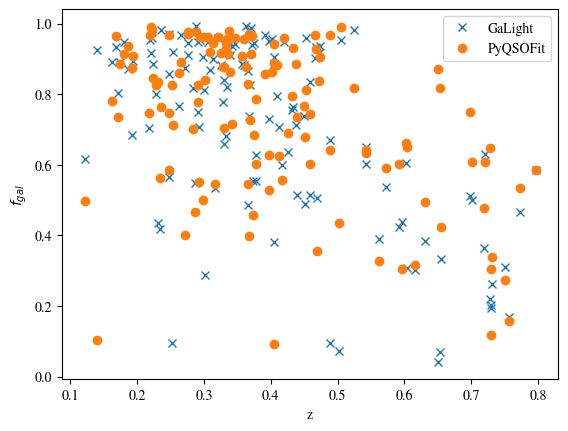

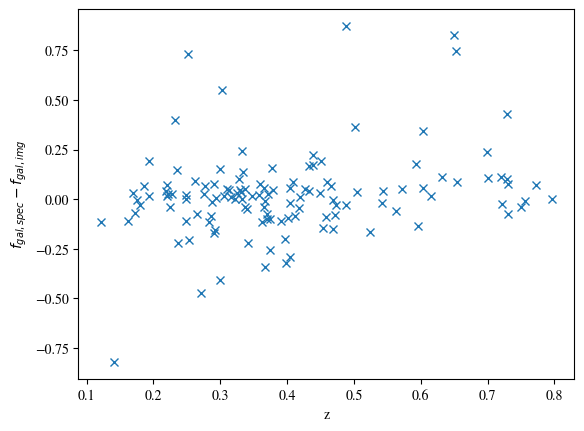

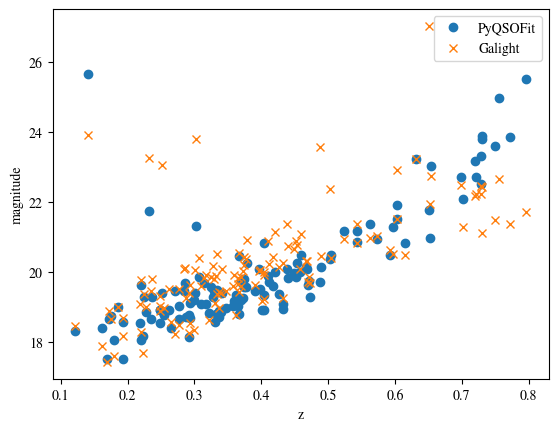

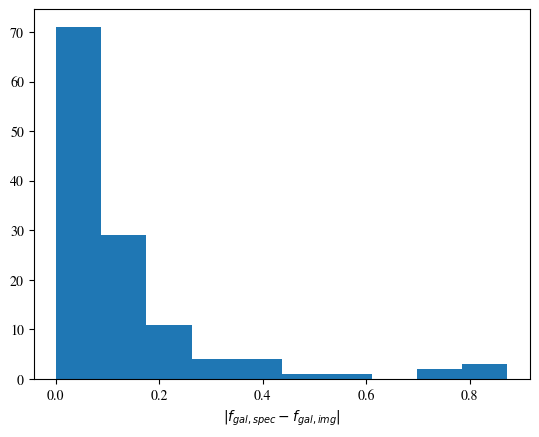

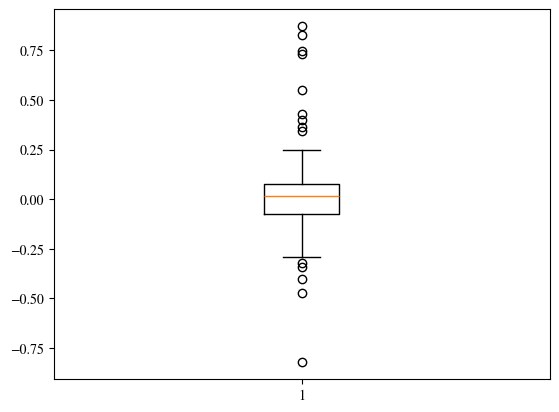

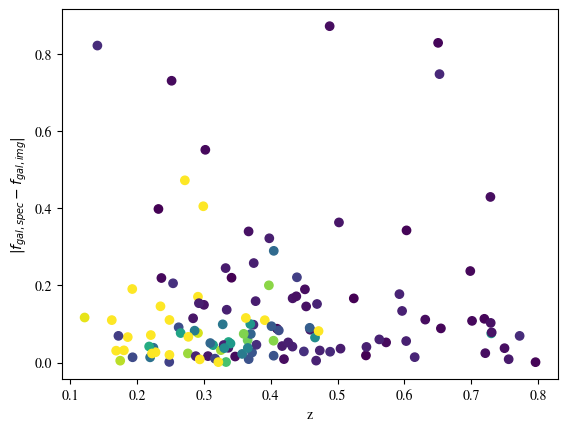

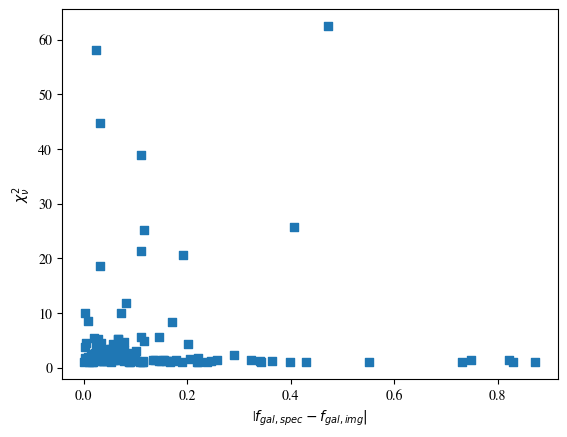

In [5]:
#automating above process

from numpy import diff





DESI_HSC = pd.read_csv('data/DESICatalogue.csv')
DESI_HSC['HSC_ID'] = DESI_HSC['HSC_ID'].astype(str)
targetList = obj_list = DESI_HSC['DESI_ID']
galaxyFractionSpec = []
galaxyFractionImage = []
specMagnitudeHost = []
imageMagnitudeHost = []
chiImg = []
z = []
for target in targetList:
    try:
        spectroscopicResult = CollectSpectroscopicData(target)
        HSCResult = pickle.load(open(f"results/desitargets/includinghost/{target}/fitting_results/{target}-result-band-r.pkl","rb"))
    except FileNotFoundError:
        continue
    
    #compare to HSC
    fluxMag0 = 63095734448.01944
    HSCGalaxyMagnitude = HSCResult.final_result_galaxy[0]["magnitude"]
    HSCQSOMagnitude = HSCResult.final_result_ps[0]["magnitude"]
    HSCHostFlux = toFlux(HSCGalaxyMagnitude,fluxMag0)
    HSCQSOFlux = toFlux(HSCQSOMagnitude,fluxMag0)
    HSCGalaxyFraction = HSCHostFlux/(HSCHostFlux+HSCQSOFlux)
    galaxyFractionImage.append(HSCGalaxyFraction)
    obj_No = list(DESI_HSC["DESI_ID"]).index(int(target))
    chiImg.append(HSCResult.reduced_Chisq)
    galaxyFractionSpec.append(spectroscopicResult["galaxy fraction"])
    z.append(list(DESI_HSC["Z_DESI"])[obj_No])
    specMagnitudeHost.append(spectroscopicResult["host magnitude"])
    imageMagnitudeHost.append(HSCGalaxyMagnitude)
difference = np.subtract(np.array(galaxyFractionSpec),np.array(galaxyFractionImage))


plt.plot(z,galaxyFractionImage,linestyle="None",marker="x",label="GaLight")
plt.plot(z,galaxyFractionSpec,linestyle="None",marker="o",label="PyQSOFit")
plt.xlabel("z")
plt.ylabel(r"$f_{gal}$")
plt.legend(loc="best")
plt.figure()
plt.plot(z,difference,linestyle="None",marker="x")
plt.xlabel("z")
plt.ylabel(r"$f_{gal,spec} - f_{gal,img}$")
plt.figure()
plt.plot(z,specMagnitudeHost,linestyle="None",marker="o",label="PyQSOFit")
plt.plot(z,imageMagnitudeHost,linestyle="None",marker="x",label="Galight")
plt.legend(loc="best")
plt.xlabel("z")
plt.ylabel("magnitude")
plt.figure()
plt.xlabel(r"$|f_{gal,spec} - f_{gal,img}|$")
plt.hist(np.abs(difference))
print(f"Mean difference: {np.mean(difference)}+-{np.std(difference)}")
plt.figure()
plt.boxplot(difference)
plt.figure()
colour = [value/(5) for value in chiImg]
for i,value in enumerate(colour):
    if value >= 1:
        colour[i] = 1
plt.scatter(z,np.abs(difference),c=colour,linestyle="None",marker="o")
plt.xlabel("z")
plt.ylabel(r"$|f_{gal,spec} - f_{gal,img}|$")
plt.figure()
plt.scatter(np.abs(difference),chiImg,marker="s")
plt.ylabel(r"$\chi^2_\nu$")
plt.xlabel(r"|$f_{gal,spec} - f_{gal,img}|$")


['39627899921240501_cont.csv', '39627652490857032_cont.csv', '39627670568314673_cont.csv', '39627896758735663_cont.csv', '39627749140204970_cont.csv', '39627751509987377_cont.csv', '39627736897033394_cont.csv', '39627745415661526_cont.csv', '39627751094747557_cont.csv', '39627815557011818_cont.csv', '39627908825747546_cont.csv', '39627769675514878_cont.csv', '39627781276959336_cont.csv', '39627786981217017_cont.csv', '39627787723605546_cont.csv', '39627793021012206_cont.csv', '39627730995647742_cont.csv', '39627799748677841_cont.csv', '39627805125775875_cont.csv', '39627805943664858_cont.csv', '39627682723402817_cont.csv', '39627737039640185_cont.csv', '39627829524041315_cont.csv', '39627835576418760_cont.csv', '39627634556017139_cont.csv', '39627848566179798_cont.csv', '39627853704202983_cont.csv', '39627860649970189_cont.csv', '39627878723227145_cont.csv', '39627628532999034_cont.csv', '39627794379967387_cont.csv', '243316956332054_cont.csv', '39627758107627755_cont.csv', '3962776420

(0.0, 6.0)

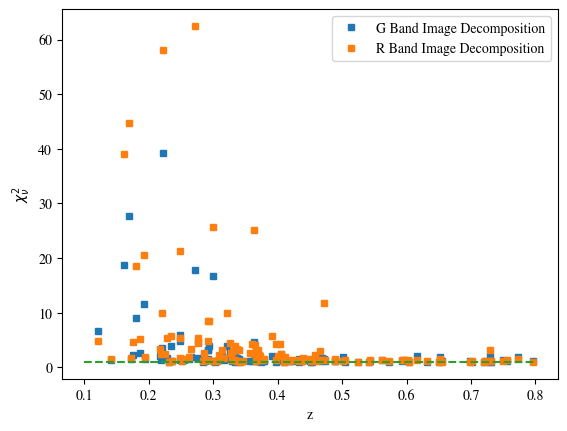

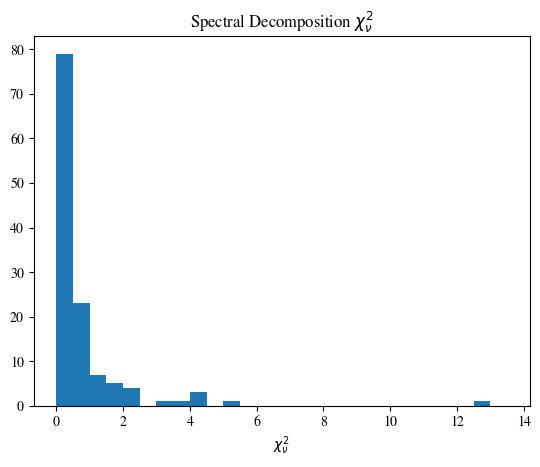

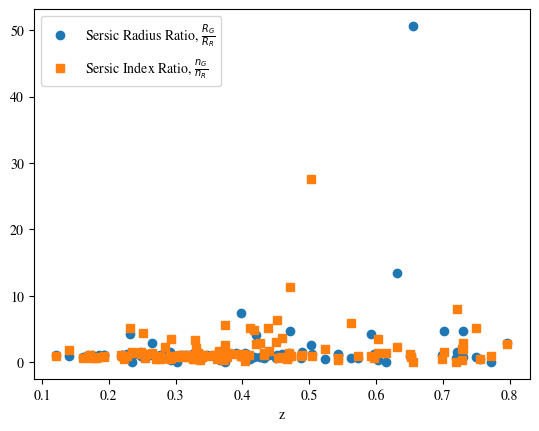

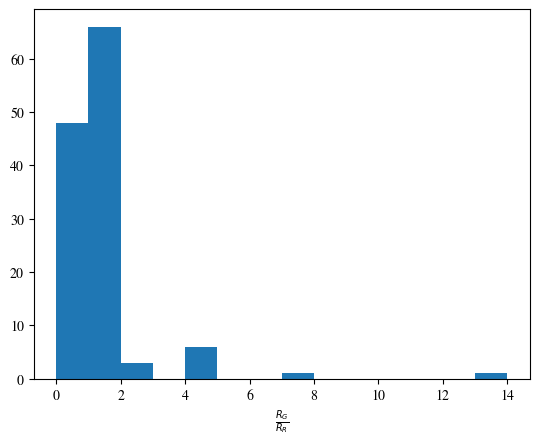

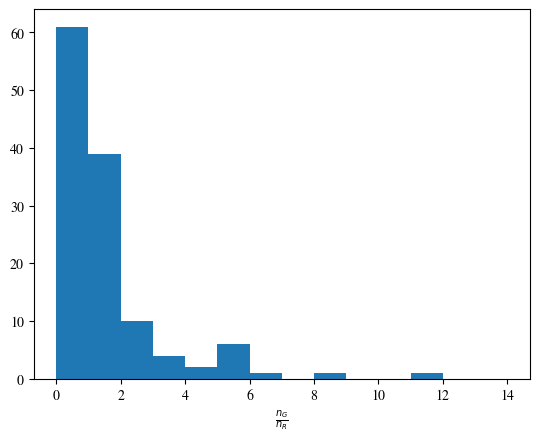

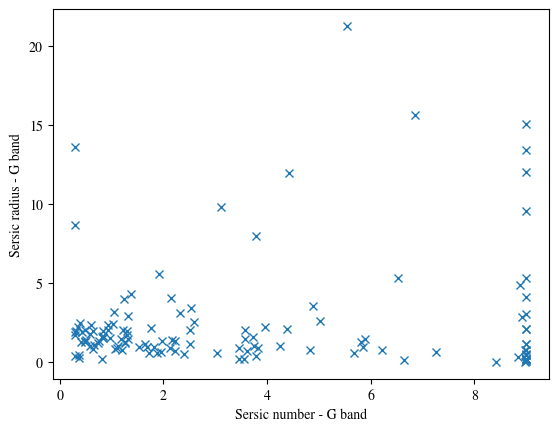

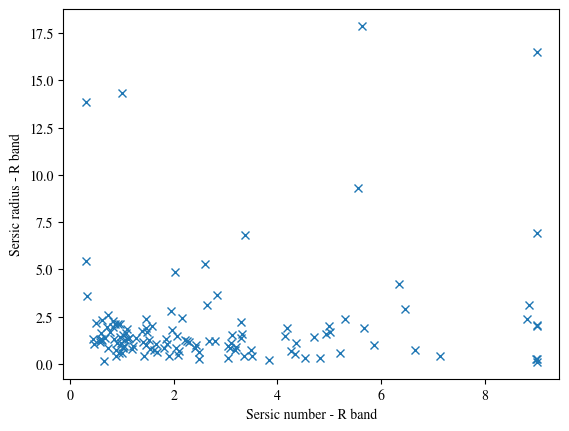

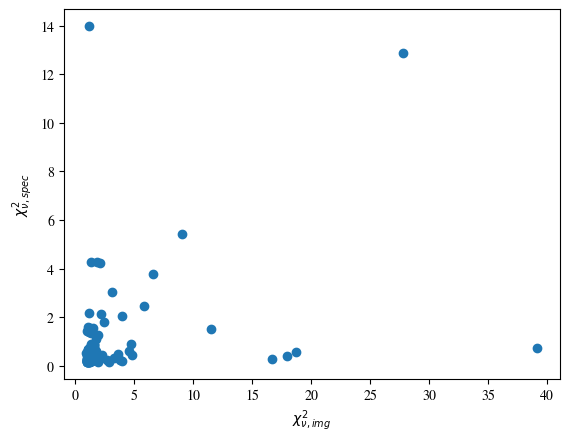

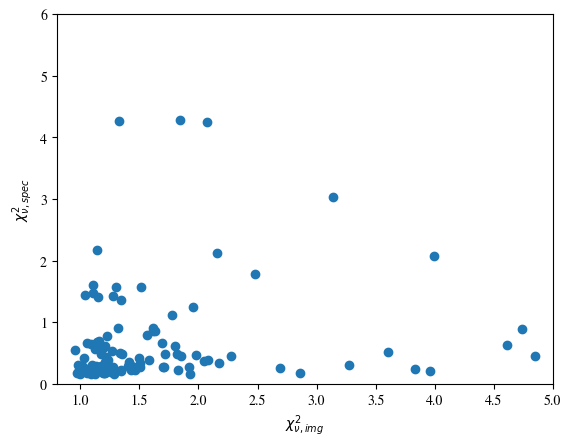

In [4]:
import matplotlib
#rchi2 comparison
DESI_HSC = pd.read_csv('data/DESICatalogue.csv')
#ffirst get list of continuum data files
specPath = r"results/PyQSOFit_test"
specFind = r".*_cont\.csv$" # search for cont csv files
specFiles = [file for file in list(os.listdir(specPath)) if re.search(specFind,file)]
print(specFiles)
imgPath = "results/desitargets/includinghost"
imgFiles = list(os.listdir(imgPath))
print(len(specFiles))
print(len(list(os.listdir(imgPath))))

print(specFiles[1][0:specFiles[1].index('_')])
#now include only spectral items which also appear in image decompositions
specFilesMatching = [fileName for fileName in specFiles if fileName[0:fileName.index('_')] in imgFiles]
print(specFilesMatching)
print(len(specFilesMatching))
objectNames = [name[:name.index('_')] for name in specFiles]

imgChiHost = {"G":[],"R":[]}
imgChiNoHost = {"G":[],"R":[]}
SersicR = {"G":[],"R":[]}
SersicN = {"G":[],"R":[]}
specChi = []

#Now gather data from both file lists
z = []
for i, object in enumerate(objectNames):
    try:
        noHostHSCResultG = pickle.load(open(f"results/desitargets/excludinghost/{object}/fitting_results/{object}-result-band-g.pkl","rb"))
        #noHostHSCResultR = pickle.load(open(f"results/desitargets/excludinghost/{object}/fitting_results/{object}-result-band-r.pkl","rb"))
        hostHSCResultG = pickle.load(open(f"results/desitargets/includinghost/{object}/fitting_results/{object}-result-band-g.pkl","rb"))
        hostHSCResultR = pickle.load(open(f"results/desitargets/includinghost/{object}/fitting_results/{object}-result-band-r.pkl","rb"))
        specResult = np.loadtxt(f"{specPath}/{specFilesMatching[i]}",delimiter=",",skiprows=1,usecols=(2))[28]
    except FileNotFoundError:
        continue
    #in specresult, rchi2decomp is the value at index 28
    SersicR["G"].append(hostHSCResultG.final_result_galaxy[0]["R_sersic"])
    SersicN["G"].append(hostHSCResultG.final_result_galaxy[0]["n_sersic"])
    SersicR["R"].append(hostHSCResultR.final_result_galaxy[0]["R_sersic"])
    SersicN["R"].append(hostHSCResultR.final_result_galaxy[0]["n_sersic"])
    imgChiHost["G"].append(hostHSCResultG.reduced_Chisq)
    obj_No = list(DESI_HSC["DESI_ID"]).index(int(object))
    z.append(list(DESI_HSC["Z_DESI"])[obj_No])
    imgChiHost["R"].append(hostHSCResultR.reduced_Chisq)
    imgChiNoHost["G"].append(noHostHSCResultG.reduced_Chisq)
    #imgChiNoHost["R"].append(noHostHSCResultR.reduced_Chisq)
    specChi.append(specResult)

sersicRadiusRatio = np.divide(SersicR["G"],SersicR["R"])
sersicIndexRatio = np.divide(SersicN["G"],SersicN["R"])

#find highest chi2 objects - above 10
highChiSquareObjects = []
for i,chi in enumerate(imgChiHost["G"]):
    if chi >= 10:
        highChiSquareObjects.append(objectNames[i])
        

        
print(highChiSquareObjects)
print(hostHSCResultG.final_result_galaxy[0])
print(len(specChi))
print(len(imgChiHost["G"]))
print(len(imgChiNoHost["G"]))
print(len(imgChiHost["R"]))
print(len(imgChiNoHost["R"]))

#compare how many sersic indices/radii are higher/lower overall in r and g band
print(f"Mean sersic index ratio: {np.mean(sersicIndexRatio)}")
print(f"Mean sersic radius ratio: {np.mean(sersicRadiusRatio)}")
plt.plot(z,imgChiHost["G"],linestyle="None",marker="s",label="G Band Image Decomposition",markersize=5)
plt.plot(z,imgChiHost["R"],linestyle="None",marker="s",label="R Band Image Decomposition",markersize=5)
#plt.plot(z,imgChiNoHost["G"],linestyle="None",marker="x",label="Image, Host Not Fitted")
#plt.plot(z,specChi,linestyle="None",marker="o",label="Spectral Decomposition",markersize=5)
plt.plot([0.1,0.8],[1,1],linestyle="dashed")
plt.legend(loc="best")
plt.xlabel("z")
plt.ylabel(r"$\chi^2_{\nu}$")
plt.figure()
plt.title(r"Spectral Decomposition $\chi^2_\nu$")
plt.hist(specChi,bins=np.arange(0,14,0.5))
plt.xlabel(r"$\chi^2_\nu$")
plt.figure()
plt.plot(z,sersicRadiusRatio,linestyle="None",marker="o",label = r"Sersic Radius Ratio, $\frac{R_G}{R_R}$")
plt.plot(z,sersicIndexRatio,linestyle="None",marker="s",label = r"Sersic Index Ratio, $\frac{n_G}{n_R}$")
plt.legend(loc="best")
plt.xlabel("z")
plt.figure()
plt.hist(sersicRadiusRatio,bins=np.arange(0,15,1))
plt.xlabel(r"$\frac{R_G}{R_R}$")
plt.figure()
plt.hist(sersicIndexRatio,bins=np.arange(0,15,1))
plt.xlabel(r"$\frac{n_G}{n_R}$")
plt.figure()
plt.xlabel("Sersic number - G band")
plt.ylabel("Sersic radius - G band")
plt.plot(SersicN["G"],SersicR["G"],linestyle="None",marker="x")
plt.figure()
plt.xlabel("Sersic number - R band")
plt.ylabel("Sersic radius - R band")
plt.plot(SersicN["R"],SersicR["R"],linestyle="None",marker="x")
plt.figure()
plt.plot(imgChiHost["G"],specChi,linestyle="None",marker="o")
plt.xlabel(r"$\chi^2_{\nu,img}$")
plt.ylabel(r"$\chi^2_{\nu,spec}$")
plt.figure()
plt.plot(imgChiHost["G"],specChi,linestyle="None",marker="o")
plt.xlabel(r"$\chi^2_{\nu,img}$")
plt.ylabel(r"$\chi^2_{\nu,spec}$")
plt.xlim(0.8,5)
plt.ylim(0,6)

['39627899921240501_cont.csv', '39627652490857032_cont.csv', '39627670568314673_cont.csv', '39627896758735663_cont.csv', '39627749140204970_cont.csv', '39627751509987377_cont.csv', '39627736897033394_cont.csv', '39627745415661526_cont.csv', '39627751094747557_cont.csv', '39627815557011818_cont.csv', '39627908825747546_cont.csv', '39627769675514878_cont.csv', '39627781276959336_cont.csv', '39627786981217017_cont.csv', '39627787723605546_cont.csv', '39627793021012206_cont.csv', '39627730995647742_cont.csv', '39627799748677841_cont.csv', '39627805125775875_cont.csv', '39627805943664858_cont.csv', '39627682723402817_cont.csv', '39627737039640185_cont.csv', '39627829524041315_cont.csv', '39627835576418760_cont.csv', '39627634556017139_cont.csv', '39627848566179798_cont.csv', '39627853704202983_cont.csv', '39627860649970189_cont.csv', '39627878723227145_cont.csv', '39627628532999034_cont.csv', '39627794379967387_cont.csv', '243316956332054_cont.csv', '39627758107627755_cont.csv', '3962776420

Text(0, 0.5, 'L5100')

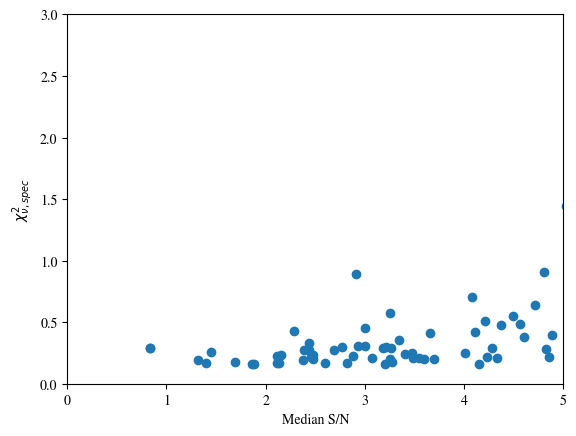

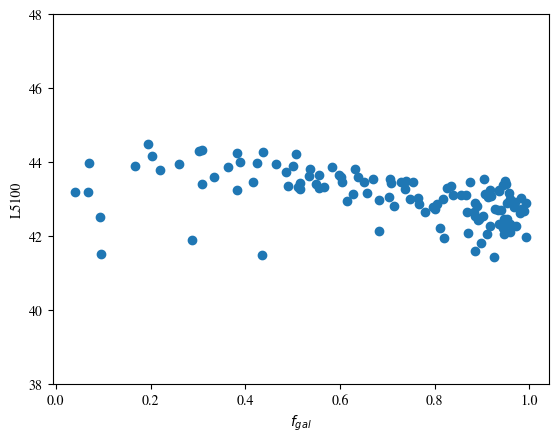

In [14]:
#go over all spectral results to plot signal/noise
def MedianSN(specFilePath):
    flux,flux_err = np.loadtxt(specFilePath,delimiter=",",skiprows=1,usecols=(2,3),unpack=True)
    SN=[]
    for i, f in enumerate(flux):
        SN.append(f/flux_err[i])
    return np.median(np.array(SN))
decSpecPath = r"results/PyQSOFit_test"
decSpecFind = r".*_cont\.csv$" # search for cont csv files
decSpecFiles = [file for file in list(os.listdir(decSpecPath)) if re.search(decSpecFind,file)]
specPath = r"data/spectra"
specFind = r".*_spec.csv$" # search for csv files
specFiles = [file for file in list(os.listdir(specPath)) if re.search(specFind,file)]
print(decSpecFiles)
objectNames = [file[:file.index('_')] for file in decSpecFiles]
print(objectNames)
print(len(decSpecFiles))
print(len(specFiles))
medianSN = []
decChi = []
imgFGal = []
L5100 = []
z = []
for i,targetName in enumerate(objectNames):
    try:
        spectroscopicResult = CollectSpectroscopicData(targetName)  
        HSCResult = pickle.load(open(f"results/desitargets/includinghost/{targetName}/fitting_results/{targetName}-result-band-r.pkl","rb"))
    except FileNotFoundError:
        continue
    medianSN.append(MedianSN(f"{specPath}/{targetName}_spec.csv"))
    decChi.append(np.loadtxt(f"{decSpecPath}/{targetName}_cont.csv",delimiter=",",skiprows=1,usecols=(2))[28])
    L5100.append(np.loadtxt(f"{decSpecPath}/{targetName}_cont.csv",delimiter=",",skiprows=1,usecols=(2))[25])
    
    fluxMag0 = 63095734448.01944
    HSCGalaxyMagnitude = HSCResult.final_result_galaxy[0]["magnitude"]
    HSCQSOMagnitude = HSCResult.final_result_ps[0]["magnitude"]
    HSCHostFlux = toFlux(HSCGalaxyMagnitude,fluxMag0)
    HSCQSOFlux = toFlux(HSCQSOMagnitude,fluxMag0)
    HSCGalaxyFraction = HSCHostFlux/(HSCHostFlux+HSCQSOFlux)
    imgFGal.append(HSCGalaxyFraction)    
    
#percentage of     
    

plt.plot(medianSN,decChi,linestyle="None",marker="o")
plt.xlabel("Median S/N")
plt.ylabel(r"$\chi^2_{\nu,spec}$")
plt.xlim(0,5)
plt.ylim(0,3)
plt.figure()
plt.plot(imgFGal,L5100,linestyle="None",marker="o")
plt.ylim(38,48)
plt.xlabel(r"$f_{gal}$")
plt.ylabel(r"L5100")

41
126


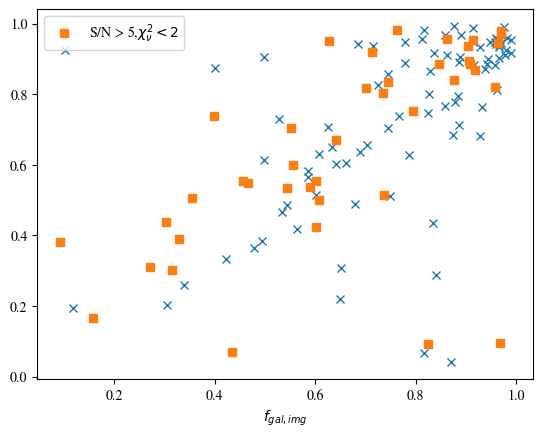

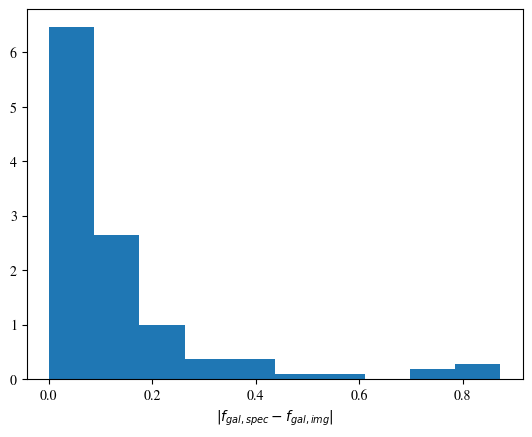

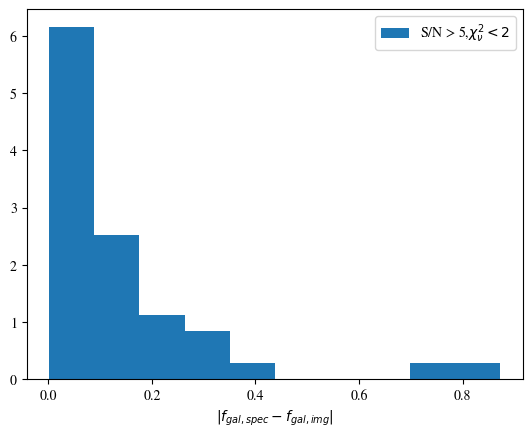

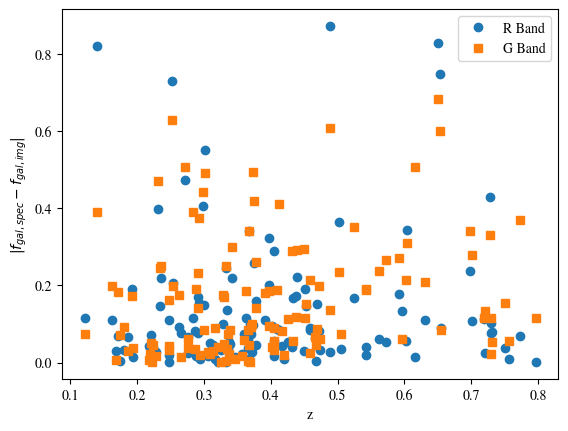

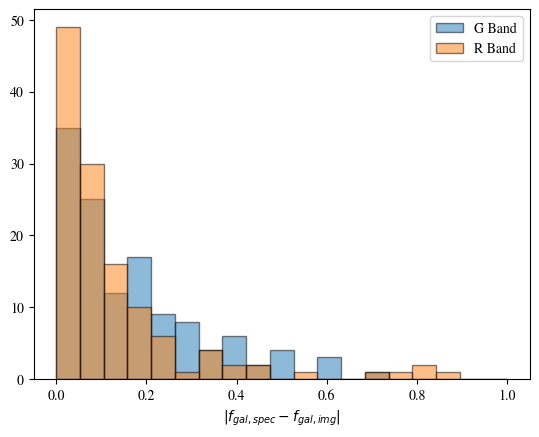

In [10]:
file = open(r"results/resultMasterlist.pkl","rb")
masterlist = pickle.load(file)
file.close()
subset1 = [element for element in masterlist if element.imgFGal["R"] is not None and element.specSN is not None] # subset of complete R band data
subset2 = [element for element in subset1 if (element.specSN >= 5) and (element.pklFiles["R"].reduced_Chisq <= 3)]
diff1 = np.abs(np.subtract([element.specFGal["R"]["galaxy fraction"] for element in subset1], [element.imgFGal["R"] for element in subset1]))
diff2 = np.abs(np.subtract([element.specFGal["R"]["galaxy fraction"] for element in subset2], [element.imgFGal["R"] for element in subset2]))

subsetGR = [element for element in masterlist if element.imgFGal["R"] is not None and element.imgFGal["G"] is not None and element.specSN is not None] # full data set
deltaR = np.abs(np.subtract([element.specFGal["R"]["galaxy fraction"] for element in subsetGR], [element.imgFGal["R"] for element in subsetGR]))
deltaG = np.abs(np.subtract([element.specFGal["G"]["galaxy fraction"] for element in subsetGR], [element.imgFGal["G"] for element in subsetGR]))

print(len(subset2))
print(len(subset1))

#
#plots
plt.plot([element.specFGal["R"]["galaxy fraction"] for element in subset1], [element.imgFGal["R"] for element in subset1], marker="x",linestyle="None")
plt.plot([element.specFGal["R"]["galaxy fraction"] for element in subset2], [element.imgFGal["R"] for element in subset2], marker="s",linestyle="None",label=r"S/N > 5,$\chi^2_\nu < 2$")
plt.legend(loc="best")
plt.xlabel(r"$f_{gal,spec}$")
plt.xlabel(r"$f_{gal,img}$")
plt.figure()
plt.hist(diff1,density=True)
plt.xlabel(r"$|f_{gal,spec}-f_{gal,img}|$")
plt.figure()
plt.hist(diff2,label=r"S/N > 5,$\chi^2_\nu < 2$",density=True)
plt.legend(loc="best")
plt.xlabel(r"$|f_{gal,spec}-f_{gal,img}|$")
plt.figure()
plt.plot([element.z for element in subsetGR],deltaR, label="R Band",linestyle="None",marker="o")
plt.plot([element.z for element in subsetGR],deltaG, label="G Band",linestyle="None",marker="s")
plt.xlabel("z")
plt.ylabel(r"$|f_{gal,spec}-f_{gal,img}|$")
plt.legend(loc="best")
plt.figure()
bins = np.linspace(0,1,20)
plt.hist(deltaG,bins,alpha=0.5,label="G Band",edgecolor="black",linewidth=1)
plt.hist(deltaR,bins,alpha=0.5,label="R Band",edgecolor="black",linewidth=1)
plt.xlabel(r"$|f_{gal,spec}-f_{gal,img}|$")
plt.legend(loc="best")


In [26]:
file = open(r"results/resultMasterlist.pkl","rb")
masterlist = pickle.load(file) #loading the masterlist object - an array of TargetData objects
file.close()
print(masterlist[0].name) #name of the object
print(masterlist[0].z) #redshift of object
print(masterlist[0].pklFiles) #image decomposition result pickle objects
print(masterlist[0].specFGal) #spectral decomposition results - including galaxy fraction
print(masterlist[0].imgFGal) #galaxy fraction from image decomposition
print(masterlist[0].specSN) #spectral S/N
print(masterlist[0].wavelength) #wavelengths of spectrum
print(masterlist[0].qsoFlux) #qso part of spectrum
print(masterlist[0].hostFlux) #host part of spectrum
print(masterlist[0].contValue) #values within _cont.csv files - outputs from spectral decomposition

39627899921240501
0.5045062913922753
{'G': <galight.fitting_process.FittingProcess object at 0x7f632b824470>, 'R': <galight.fitting_process.FittingProcess object at 0x7f632c5455b0>}
{'G': {'host magnitude': 20.452914522378776, 'qso magnitude': 24.795852789440236, 'galaxy fraction': 0.9817056082210861}, 'R': {'host magnitude': 20.47957695741967, 'qso magnitude': 25.350874167331714, 'galaxy fraction': 0.9889021167337785}}
{'G': 0.908298218898956, 'R': 0.952742527360044}
1.692108654573038
[3450.16835735 3450.70009325 3451.23182914 ... 6525.72877639 6526.26051229
 6526.79224818]
[0.04169466 0.04171096 0.04172726 ... 0.03471393 0.03505873 0.03540353]
[0.36229244 0.36491533 0.36572015 ... 1.30341115 1.30288219 1.30235323]
[-9.99000000e+02 -9.99000000e+02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.04506291e-01  3.10272544e+00  0.00000000e+00
  3.00000000e+03  0.00000000e+00  4.38082903e-02  1.35839059e+03
  1.47968992e-03  5.08482145e-03 -6.35303787e-01  0.00000000e+00
  1.50000000e+